To run this example notebook:
* pandas, numy, MulticoreTSNE are needed for this notebook.
* bacteria model files and lshvec java library are required to be downloaded (refer to project README)
* install PyLSHVec (pip, docker or from code)
* Be warning that jnius may not work on your environment. Refer to https://github.com/kivy/pyjnius for trouble shooting.

# Introduction

In https://github.com/Lizhen0909/LSHVec, an vector embedding are trained on a Nanorpore reads data, And use TSNE to visualize the vectors.

In this notebook the vectors of a pretrained classfication model are used to show a similar visualization.

Although in theory the vectors in classfication model is not good as the vectors in embedding model, in this notebook we will see that the its visulation is not bad.

In [1]:
%pylab inline
import sys,os
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


### Download the sequence file frist

In [5]:
if not os.path.exists("/mnt/ActinoMock_Nanopore.seq.gz"):
    !cd /mnt && wget http://ww2.cs.fsu.edu/~lshi/ActinoMock_Nanopore.seq.gz

--2019-10-29 18:42:10--  http://ww2.cs.fsu.edu/~lshi/ActinoMock_Nanopore.seq.gz
Resolving ww2.cs.fsu.edu (ww2.cs.fsu.edu)... 128.186.122.20
Connecting to ww2.cs.fsu.edu (ww2.cs.fsu.edu)|128.186.122.20|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 480042209 (458M) [application/x-gzip]
Saving to: ‘ActinoMock_Nanopore.seq.gz’

ActinoMock_Nanopore 100%[===================>] 457.80M  36.5MB/s    in 14s     

2019-10-29 18:42:24 (33.7 MB/s) - ‘ActinoMock_Nanopore.seq.gz’ saved [480042209/480042209]



### Read the data. The data file was already shuffled. We only take the first 20000. 

In [2]:
seqs = pd.read_csv("/mnt/ActinoMock_Nanopore.seq.gz",sep='\t', header=None, usecols=None,index_col=0, nrows=20000)
seqs.columns=['id','seq']
seqs['organism']=seqs['id'].map(lambda u: u.split('-')[1])
seqs['class']=seqs['id'].map(lambda u: u.split('-')[2])
seqs['phylum']=seqs['id'].map(lambda u: u.split('-')[3])
seqs.head()

,id,seq,organism,class,phylum
0,,,,,
47914,47914-2616644829-Gammaproteobacteria-Proteobac...,GTGATTGCCTGCCGGTCTCACAGGTTTCATCCTTCATGCTTTTTTC...,2616644829,Gammaproteobacteria,Proteobacteria
78419,78419-2623620618-Gammaproteobacteria-Proteobac...,GGAGCGCAAGGAATCGTCGATATTTTGCACTCGGTTTGCATAAGCG...,2623620618,Gammaproteobacteria,Proteobacteria
67045,67045-2623620617-Gammaproteobacteria-Proteobac...,CGCCGTGCGTACCGCCGCAAAGAGTGAGTCTTGAAGATGTCGCGGT...,2623620617,Gammaproteobacteria,Proteobacteria
27710,27710-2615840601-Alphaproteobacteria-Proteobac...,CAACTCGCGGATCAGTTCCTGCTGAGGAAGCGCAAATCTTCATCTG...,2615840601,Alphaproteobacteria,Proteobacteria
31701,31701-2615840697-Gammaproteobacteria-Proteobac...,AAATAATAAATTCTCTCTGCCTTAACAGACGTATCACCTCCAACTT...,2615840697,Gammaproteobacteria,Proteobacteria


### load model

In [3]:
if 0: #dirty fix
    sys.path.insert(0,"../src/")
    os.environ['JAVA_HOME']='/usr/lib/jvm/java-openjdk/'

In [4]:
from pylshvec import *

In [5]:
#here needs jlshvec jar file, download it first
set_lshvec_jar_path("/mnt/jlshvec-assembly-0.1.jar")

In [6]:
#since vector model is usually large, set a big java memory limit is preferred. 
add_java_options("-Xmx32G")

In [7]:
#here need model file and lsh function file, download them first
model= LSHVec(model_file="/mnt/refdb_bacteria_model_gs_k23_l3000_rand_m299", 
              hash_file="/mnt/lsh_nt_NonEukaryota_k23_h25.crp", num_thread=8)

### get the embeddings

In [17]:
%%time
seqvecs = [np.array(u,np.float32) for u in model.embedding(seqs['seq'][:])]

CPU times: user 1h 37min 47s, sys: 7.74 s, total: 1h 37min 54s
Wall time: 13min 2s


In [18]:
seqs['vec']=seqvecs

### train TSNE

In [23]:
from MulticoreTSNE import MulticoreTSNE as TSNE


In [24]:
tsne = TSNE(n_components=2, perplexity=100, n_jobs=8)
X=np.array(list(seqs['vec'].values))
X.shape

(20000, 100)

In [25]:
%time Y = tsne.fit_transform(X)

CPU times: user 6min 36s, sys: 330 ms, total: 6min 37s
Wall time: 1min 18s


### Visulization

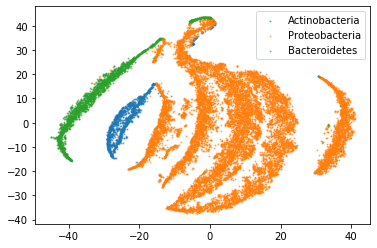

In [26]:
labels=seqs['phylum'].values
legends=list(set(labels))
for label in legends:            
    plt.scatter(Y[labels==label][:,0],Y[labels==label][:,1],alpha=0.5,s=1)
plt.legend(legends)

['Alphaproteobacteria', 'Flavobacteriia', 'Actinobacteria', 'Gammaproteobacteria']


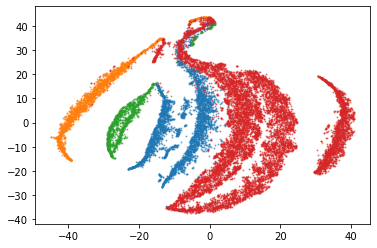

In [27]:
labels=seqs['class'].values
legends=list(set(labels))
print (legends)
for label in legends:            
    plt.scatter(Y[labels==label][:,0],Y[labels==label][:,1],alpha=0.5,s=1)

['2623620567', '2615840697', '2616644829', '2623620617', '2617270709', '2623620557', '2623620618', '2615840646', '2615840527', '2615840601', '2615840533']


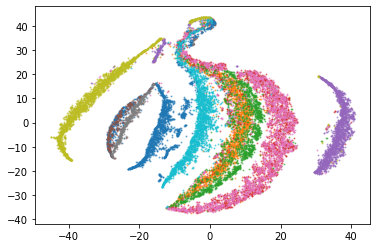

In [28]:
labels=seqs['organism'].values
legends=list(set(labels))
print (legends)
for label in legends:            
    plt.scatter(Y[labels==label][:,0],Y[labels==label][:,1],alpha=0.5,s=1)